In [ ]:
!pip install scikit-surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163484 sha256=e9be0c69bfe4f9db4e7d1031023bdfee560d7ba89f7dc81dd355dda23f78aead
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import numpy as np
import keras
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation
from surprise import Reader, Dataset, SVD, NormalPredictor, BaselineOnly, KNNBasic, NMF
from surprise.model_selection import cross_validate, KFold ,GridSearchCV , RandomizedSearchCV
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import  Input, dot, concatenate
from keras.models import Model
from IPython.display import SVG

from keras.utils import model_to_dot
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# import data rating dan panda sebagai data frame
data = pd.read_csv("./tourism_rating.csv")
#data = pd.DataFrame(data, columns=["user", "item", "rating", "timestamp"]).drop(columns=['timestamp'])


In [ ]:
from sklearn.model_selection import train_test_split
data = data.sample(frac = 1)
data_train_x = np.array(data[['User_Id' , 'Place_Id']].values)
data_train_y = np.array(data['Place_Ratings'].values)
x_train, x_test, y_train, y_test = train_test_split(data_train_x, data_train_y, test_size = 0.2, random_state = 98)
n_factors = 50
n_users = data['User_Id'].max()
n_movies = data['Place_Id'].max()

In [ ]:
user_input = Input(shape=(1,), name='User_Input')
user_embeddings = Embedding(input_dim = n_users+1, output_dim=n_factors, input_length=1,name='User_Embedding')(user_input)
user_vector = Flatten(name='User_Vector') (user_embeddings)

movie_input = Input(shape = (1,) , name = 'Movie_input')
movie_embeddings = Embedding(input_dim = n_movies+1 , output_dim = n_factors , input_length = 1 , name = 'Movie_Embedding')(movie_input)
movie_vector = Flatten(name = 'Movie_Vector')(movie_embeddings)

merged_vectors = concatenate([user_vector, movie_vector], name='Concatenation')
dense_layer_1 = Dense(100 , activation = 'relu')(merged_vectors)
dense_layer_3 = Dropout(.5)(dense_layer_1)
dense_layer_2 = Dense(1)(dense_layer_3)
model = Model([user_input, movie_input], dense_layer_2)

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam' ,metrics = ['accuracy'] )
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 User_Input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Movie_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 User_Embedding (Embedding)  (None, 1, 50)                15050     ['User_Input[0][0]']          
                                                                                                  
 Movie_Embedding (Embedding  (None, 1, 50)                21900     ['Movie_input[0][0]']         
 )                                                                                            

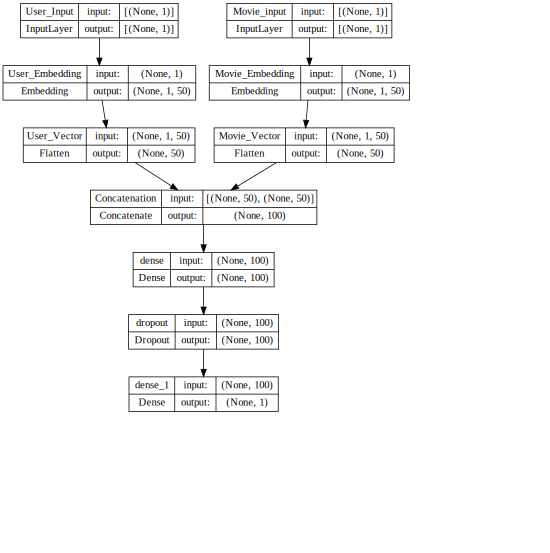

In [ ]:
SVG(model_to_dot( model,  show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [ ]:
history = model.fit(x = [x_train[:,0] , x_train[:,1]] , y =y_train , batch_size = 128 , epochs = 30 , validation_data = ([x_test[:,0] , x_test[:,1]] , y_test))

Epoch 1/30
63/63 [==============================] - 4s 8ms/step - loss: 8.2631 - accuracy: 0.0759 - val_loss: 3.1002 - val_accuracy: 0.1725
Epoch 2/30
63/63 [==============================] - 0s 4ms/step - loss: 2.2008 - accuracy: 0.1701 - val_loss: 2.0481 - val_accuracy: 0.1725
Epoch 3/30
63/63 [==============================] - 0s 5ms/step - loss: 1.9909 - accuracy: 0.1701 - val_loss: 2.1024 - val_accuracy: 0.1725
Epoch 4/30
63/63 [==============================] - 0s 4ms/step - loss: 1.9814 - accuracy: 0.1701 - val_loss: 2.1256 - val_accuracy: 0.1725
Epoch 5/30
63/63 [==============================] - 0s 4ms/step - loss: 1.9846 - accuracy: 0.1701 - val_loss: 2.1235 - val_accuracy: 0.1725
Epoch 6/30
63/63 [==============================] - 0s 4ms/step - loss: 1.9629 - accuracy: 0.1701 - val_loss: 2.1305 - val_accuracy: 0.1725
Epoch 7/30
63/63 [==============================] - 0s 4ms/step - loss: 1.9475 - accuracy: 0.1701 - val_loss: 2.1466 - val_accuracy: 0.1725
Epoch 8/30
63/63 [==

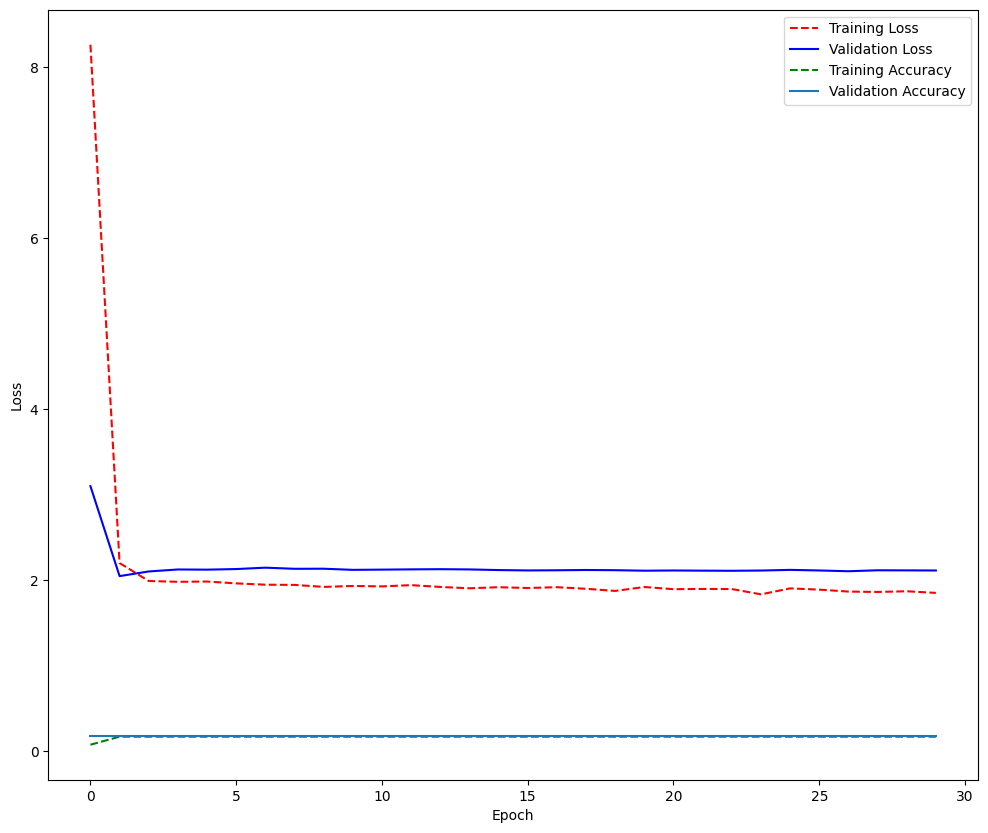

In [ ]:
loss , val_loss , accuracy , val_accuracy = history.history['loss'],history.history['val_loss'],history.history['accuracy'],history.history['val_accuracy']


plt.figure(figsize = (12,10))
plt.plot( loss, 'r--')
plt.plot(val_loss, 'b-')
plt.plot( accuracy, 'g--')
plt.plot(val_accuracy,'-')
plt.legend(['Training Loss', 'Validation Loss' , 'Training Accuracy' , 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
score = model.evaluate([x_test[:,0], x_test[:,1]], y_test)
print(np.sqrt(score))

63/63 [==============================] - 0s 2ms/step - loss: 2.1137 - accuracy: 0.1725
[1.4538433  0.41533119]


In [ ]:
df_n_ratings = pd.DataFrame(data.groupby('Place_Id')['Place_Ratings'].mean())
df_n_ratings['total ratings'] = pd.DataFrame(data.groupby('Place_Id')['Place_Id'].count())
df_n_ratings.rename(columns = {'rating': 'mean ratings'}, inplace=True)

df_n_ratings.sort_values('total ratings', ascending=False).head(10)

,Place_Ratings,total ratings
Place_Id,,
177,3.153846,39
298,2.769231,39
437,3.289474,38
201,3.108108,37
208,3.333333,36
244,3.147059,34
167,3.323529,34
29,2.636364,33
344,2.787879,33


<ipython-input-12-bea5023d69ce>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_n_ratings['total ratings'], bins=20)


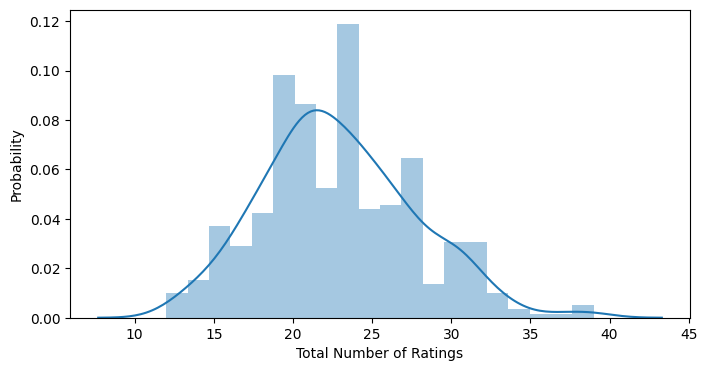

In [ ]:
plt.figure(figsize=(8,4))
sns.distplot(df_n_ratings['total ratings'], bins=20)
plt.xlabel('Total Number of Ratings')
plt.ylabel('Probability')
plt.show()

<ipython-input-15-c8f7dd8d8240>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_n_ratings['Place_Ratings'], bins=30)


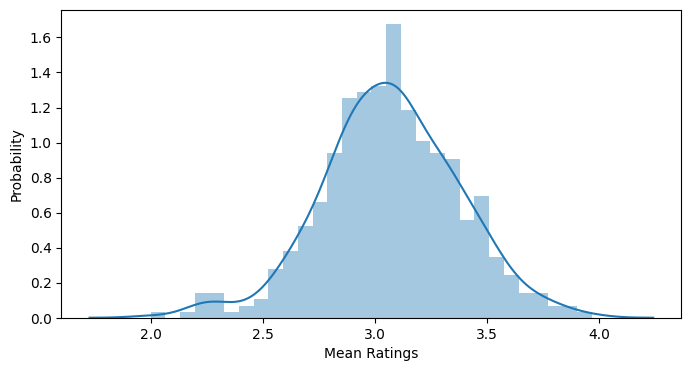

In [ ]:
plt.figure(figsize=(8,4))
sns.distplot(df_n_ratings['Place_Ratings'], bins=30)
plt.xlabel('Mean Ratings')
plt.ylabel('Probability')
plt.show()

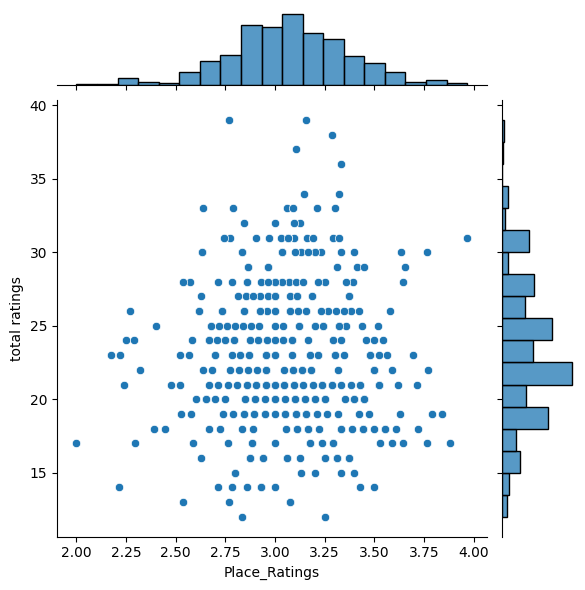

In [ ]:
sns.jointplot(x = 'Place_Ratings', y = 'total ratings', data = df_n_ratings )